In [63]:
import numpy
import iris
import os, sys
import warnings
warnings.filterwarnings('ignore')

import iris.plot as iplt
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context('talk')

cwd = os.getcwd()
repo_dir = '/'
for directory in cwd.split('/')[1:]:
    repo_dir = os.path.join(repo_dir, directory)
    if directory == 'ocean-analysis':
        break

modules_dir = os.path.join(repo_dir, 'modules')
sys.path.append(modules_dir)

import convenient_universal as uconv

In [64]:
%matplotlib inline

In [18]:
data_file = '/g/data/r87/dbi599/DRSv2/CMIP5/NorESM1-M/historical/yr/ocean/r1i1p1/ohc/latest/ohc_Oyr_NorESM1-M_historical_r1i1p1_185001-185312.nc'
ref_file = '/g/data/ua6/DRSv2/CMIP5/NorESM1-M/historical/mon/atmos/r1i1p1/rsdt/latest/rsdt_Amon_NorESM1-M_historical_r1i1p1_185001-200512.nc'

In [19]:
data_cube = iris.load_cube(data_file, 'ocean heat content')
print(data_cube)

ocean heat content                         (time: 4; cell index along second dimension: 384; cell index along first dimension: 320)
     Dimension coordinates:
          time                                  x                                     -                                      -
          cell index along second dimension     -                                     x                                      -
          cell index along first dimension      -                                     -                                      x
     Auxiliary coordinates:
          latitude                              -                                     x                                      x
          longitude                             -                                     x                                      x
     Attributes:
          Conventions: CF-1.5
          associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_ocean_fx_NorESM1-M_histo

In [20]:
ref_cube = iris.load_cube(ref_file, 'toa_incoming_shortwave_flux')[0]
print(ref_cube)

toa_incoming_shortwave_flux / (W m-2) (latitude: 96; longitude: 144)
     Dimension coordinates:
          latitude                             x              -
          longitude                            -              x
     Scalar coordinates:
          time: 1850-01-16 12:00:00, bound=(1850-01-01 00:00:00, 1850-02-01 00:00:00)
     Attributes:
          Conventions: CF-1.4
          associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_atmos_fx_NorESM1-M_historical_r0i0p0.nc...
          branch_time: 255135.0
          cmor_version: 2.6.0
          comment: at the top of the atmosphere
          contact: Please send any requests or bug reports to noresm-ncc@met.no.
          creation_date: 2011-06-01T09:30:41Z
          experiment: historical
          experiment_id: historical
          forcing: GHG, SA, Oz, Sl, Vl, BC, OC
          frequency: mon
          history: 2011-06-01T09:30:40Z altered by CMOR: Converted units from 'W/m2' to 'W

/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/iris/fileformats/cf.py:798: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'rsdt'
  warnings.warn(message % (variable_name, nc_var_name))


In [22]:
def create_region_mask(latitude_array, target_shape, lat_bounds):
    """Create mask from the latitude auxillary coordinate"""

    target_ndim = len(target_shape)

    southern_lat, northern_lat = lat_bounds
    mask_array = numpy.where((latitude_array >= southern_lat) & (latitude_array < northern_lat), False, True)

    mask = uconv.broadcast_array(mask_array, [target_ndim - 2, target_ndim - 1], target_shape)
    assert mask.shape == target_shape 

    return mask


def extract_region_curvilinear(cube, lat_bounds):
    """Extract region of interest from a curvilinear grid."""

    cube = cube.copy() 
 
    region_mask = create_region_mask(cube.coord('latitude').points, cube.shape, lat_bounds)
    land_ocean_mask = cube.data.mask
    complete_mask = region_mask + land_ocean_mask

    cube.data = numpy.ma.asarray(cube.data)
    cube.data.mask = complete_mask

    return cube

In [30]:
coord_names = [coord.name() for coord in data_cube.dim_coords]
coord_names

['time',
 'cell index along second dimension',
 'cell index along first dimension']

In [31]:
new_lat_bounds = ref_cube.coord('latitude').bounds

In [36]:
ntime = data_cube.shape[0]
nlat = len(new_lat_bounds)
new_data = numpy.ma.zeros((ntime, nlat))

In [57]:
for lat_index in range(0, nlat):
    lat_cube = extract_region_curvilinear(data_cube, new_lat_bounds[lat_index])
    lat_integral = lat_cube.collapsed(coord_names[1:], iris.analysis.SUM)
    new_data[:, lat_index] = lat_integral.data

In [58]:
new_data

masked_array(data =
 [[-- -- -- -- -- -- 8.073305014541207e+21 2.6356429350109498e+23
  7.432417877482025e+23 2.4299478840677004e+24 4.839530604391019e+24
  6.175549059908354e+24 1.121888939419925e+25 1.145684372645517e+25
  1.9388942259184963e+25 1.6257673403972293e+25 2.346539734690777e+25
  1.8707512632103093e+25 2.511331443318993e+25 1.7627224663489544e+25
  2.388656544469627e+25 2.5214233564696226e+25 2.056802924628462e+25
  2.90887140367325e+25 2.271479469729313e+25 3.11639381009069e+25
  2.435846821579313e+25 3.3354245724356986e+25 2.533081899494789e+25
  3.2057982072071042e+25 2.2254724656776546e+25 2.9124290172034813e+25
  2.865724953951024e+25 2.1046467446981977e+25 3.2728773869354215e+25
  2.4359440877004e+25 2.7428762475683406e+25 2.4806087911928193e+25
  2.7494192778842716e+25 2.5565949939291993e+25 2.9395735581177016e+25
  2.9322314934436207e+25 3.300512199470887e+25 2.8601842053260073e+25
  2.8867012901681996e+25 2.7662009180584346e+25 2.7762413692038306e+25
  2.81392799

In [59]:
new_data[0, :].sum()

1.5558972140441873e+27

In [60]:
data_cube.data[0, ::].sum()

1.5558972140441873e+27

In [61]:
time_coord = data_cube.coord('time')
lat_coord = ref_cube.coord('latitude')

new_cube = iris.cube.Cube(new_data,
                          standard_name=data_cube.standard_name,
                          long_name=data_cube.long_name,
                          var_name=data_cube.var_name,
                          units=data_cube.units,
                          attributes=data_cube.attributes,
                          dim_coords_and_dims=[(time_coord, 0), (lat_coord, 1)],)

In [62]:
print(new_cube)

ocean heat content / (J)            (time: 4; latitude: 96)
     Dimension coordinates:
          time                           x            -
          latitude                       -            x
     Attributes:
          Conventions: CF-1.5
          associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_ocean_fx_NorESM1-M_historical_r0i0p0.nc...
          branch_time: 255135.0
          cmor_version: 2.5.9
          contact: Please send any requests or bug reports to noresm-ncc@met.no.
          creation_date: 2011-05-17T00:00:06Z
          depth_bounds: OHC integrated over full depth of input data (0.000000 down to 6750.00...
          experiment: historical
          experiment_id: historical
          forcing: GHG, SA, Oz, Sl, Vl, BC, OC
          frequency: mon
          history: Thu May 31 11:50:38 2018: /g/data/r87/dbi599/miniconda3/envs/ocean/bin/python...
          initialization_method: 1
          institute_id: NCC
          ins

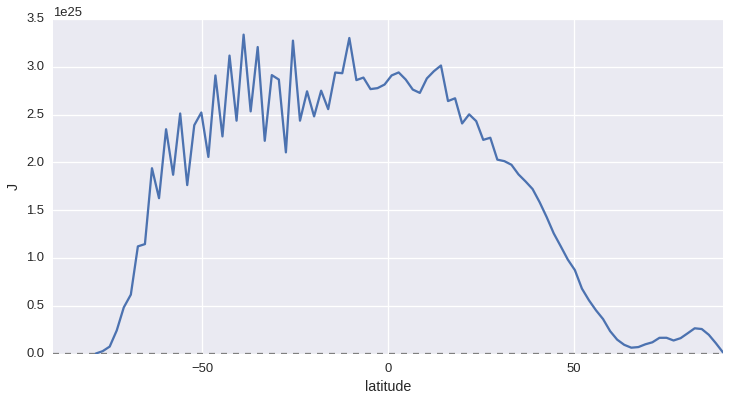

In [66]:
fig, ax = plt.subplots(figsize=[12, 6])

iplt.plot(new_cube[2, :])

plt.xlabel('latitude')
plt.ylabel('J')
plt.xlim(-90, 90)

plt.axhline(y=0, color='0.5', linestyle='--')
plt.show()